## Assignment
1. Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

5. Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.


In [2]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests
import unicodedata
import re
from bs4 import BeautifulSoup

# www.topuniversities.com

## Methodology

<span style="color:blue">After examing the webpage, we identify the URL of a JSON file that contains the ranking. Working with JSON is much simpler than working with HTML, so we perform an HTTP GET on that URL, providing a suitable timestamp value (`?_=...`). We then parse the JSON and extract the information we are interested in.</span>  

<span style="color:blue">As indicated in the problem statement, some stats are not available in the main list. We visit each university URL to extract the missing stats and scrap the HTML using BeautifulSoup.  

<span style="color:blue">Finally, we put all this data in a dataframe</span>

In [3]:
BASE_URL_TOP = 'https://www.topuniversities.com'
RANKING_URL_TOP = '/sites/default/files/qs-rankings-data/357051.txt?_=%d'

In [41]:
# Helper function to extract a metric using a CSS selector
def extract_metric(soup, selector):
    try:
        return int(soup.select(selector)[0].get_text().replace(',', ''))
    except:
        return None

# Function to obtain and format the top n universities in the ranking
def get_list_top(n=200):
    # Request the JSON data
    timestamp = int(time.time() * 1000)
    r = requests.get((BASE_URL_TOP + RANKING_URL_TOP) % timestamp)
    raw_ranking = r.json()['data'][0:n]
    
    # Process and clean each entry in the ranking, fetching the detailed page and extracting the necessary information
    ranking = []
    for entry in raw_ranking:
        rank = int(entry['rank_display'].replace('=', '')) # drop the = for tied ranks
        name = entry['title']
        country = entry['country']
        region = entry['region']
        r = requests.get(BASE_URL_TOP + entry['url'])
        soup = BeautifulSoup(r.text, 'lxml')
        total_students = extract_metric(soup, 'div.total.student .number')
        total_int_students = extract_metric(soup, 'div.total.inter .number')
        total_faculty = extract_metric(soup, 'div.total.faculty .number')
        total_int_faculty = extract_metric(soup, 'div.inter.faculty .number')
        ranking.append({'rank': rank, 'name': name, 'country': country, 'region': region, 'total_students': total_students, 'total_int_students': total_int_students, 'total_faculty': total_faculty, 'total_int_faculty': total_int_faculty})        
    
    # Create the dataframe and index it
    df = pd.DataFrame(ranking)
    df = df.set_index('rank')
    df = df.reindex_axis(['name', 'country', 'region', 'total_students', 'total_int_students', 'total_faculty', 'total_int_faculty'], axis=1)
    return df
    
# Let's see what it looks like...
top_df = get_list_top()
top_df.head()

,name,country,region,total_students,total_int_students,total_faculty,total_int_faculty
rank,,,,,,,
1,Massachusetts Institute of Technology (MIT),United States,North America,11067.0,3717.0,2982.0,1679.0
2,Stanford University,United States,North America,15878.0,3611.0,4285.0,2042.0
3,Harvard University,United States,North America,22429.0,5266.0,4350.0,1311.0
4,California Institute of Technology (Caltech),United States,North America,2255.0,647.0,953.0,350.0
5,University of Cambridge,United Kingdom,Europe,18770.0,6699.0,5490.0,2278.0


Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?

,name,faculty_to_students_ratio
rank,,
4,California Institute of Technology (Caltech),0.422616
16,Yale University,0.398323
6,University of Oxford,0.342292
5,University of Cambridge,0.292488
17,Johns Hopkins University,0.276353
2,Stanford University,0.269870
1,Massachusetts Institute of Technology (MIT),0.269450
186,University of Rochester,0.266604
19,University of Pennsylvania,0.266437


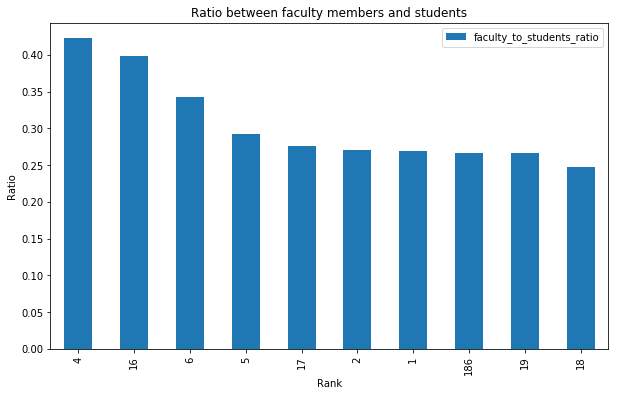

In [84]:
df = top_df.copy()
df['faculty_to_students_ratio'] = df['total_faculty'] / df['total_students']
highest_faculty_to_student = df.sort_values('faculty_to_students_ratio', ascending=False).head(10).loc[:, ['name', 'faculty_to_students_ratio']]

p1 = highest_faculty_to_student.plot(kind='bar',title='Ratio between faculty members and students',figsize=(10,6))
p1.set_ylabel("Ratio")
p1.set_xlabel("Rank")
#p1.set_xticklabels(highest_faculty_to_student.name)
highest_faculty_to_student

The graph above

,name,int_to_students_ratio
rank,,
35,London School of Economics and Political Scien...,69.139344
12,Ecole Polytechnique Fédérale de Lausanne (EPFL...,57.004738
8,Imperial College LondonImperial College London...,54.356743
200,Maastricht UniversityMaastricht UniversityMaas...,50.253280
47,Carnegie Mellon UniversityCarnegie Mellon Univ...,47.806229
7,UCL (University College London)UCL (University...,47.792793
92,University of St AndrewsUniversity of St Andre...,45.795455
41,The University of MelbourneThe University of M...,42.743350
127,Queen Mary University of LondonQueen Mary Univ...,42.181593


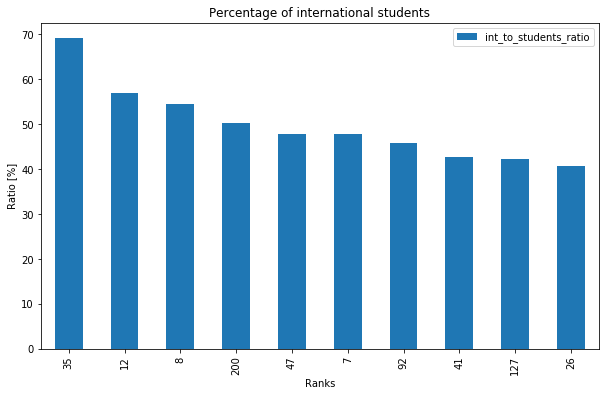

In [86]:
df = top_df.copy()
df['int_to_students_ratio'] = df['total_int_students'] / df['total_students']
highest_int_students = 100*df.sort_values('int_to_students_ratio', ascending=False).head(10).loc[:, ['name', 'int_to_students_ratio']]
p2 = highest_int_students.plot(kind='bar',title='Percentage of international students',figsize=(10,6))
p2.set_ylabel("Ratio [%]")
p2.set_xlabel("Ranks")
highest_int_students

Answer the previous question aggregating the data by (c) country and (d) region.

In [56]:
country_df = top_df.copy()
country_df = country_df.groupby('country').agg({'total_students': 'sum', 'total_int_students': 'sum', 'total_faculty': 'sum', 'total_int_faculty': 'sum'})

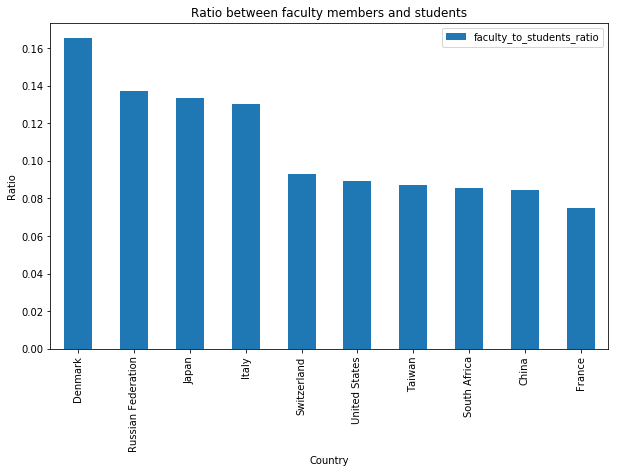

In [89]:
df = country_df.copy()
df['faculty_to_students_ratio'] = df['total_faculty'] / df['total_students']
country_faculty_to_student = df.sort_values('faculty_to_students_ratio', ascending=False).head(10).loc[:, ['faculty_to_students_ratio']]
p3 = country_faculty_to_student.plot(kind='bar',title='Ratio between faculty members and students by country',figsize=(10,6))
p3.set_ylabel("Ratio")
p3.set_xlabel("Country")

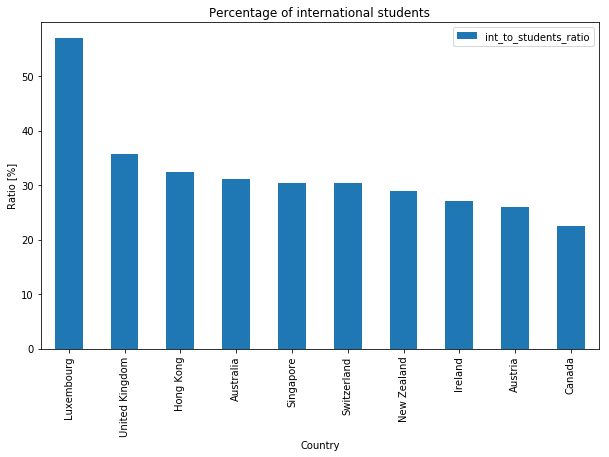

In [88]:
df = country_df.copy()
df['int_to_students_ratio'] = df['total_int_students'] / df['total_students']
country_int_to_students = 100*df.sort_values('int_to_students_ratio', ascending=False).head(10).loc[:, ['int_to_students_ratio']]

p4 = country_int_to_students.plot(kind='bar',title='Percentage of international students per country',figsize=(10,6))
p4.set_ylabel("Ratio [%]")
p4.set_xlabel("Country")

In [59]:
region_df = top_df.copy()
region_df = region_df.groupby('region').agg({'total_students': 'sum', 'total_int_students': 'sum', 'total_faculty': 'sum', 'total_int_faculty': 'sum'})

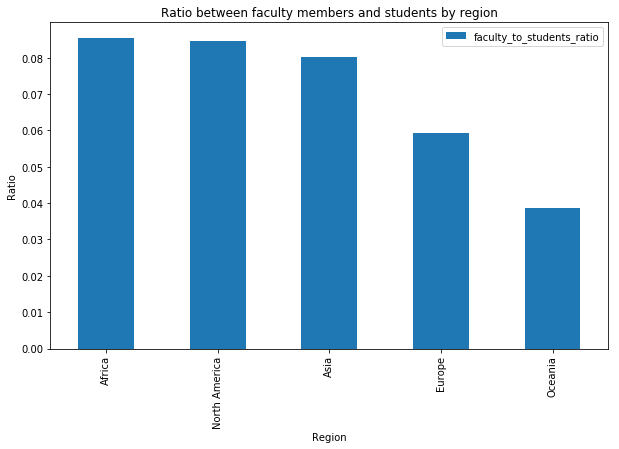

In [91]:
df = region_df.copy()
df['faculty_to_students_ratio'] = df['total_faculty'] / df['total_students']
region_faculty_to_student = df.sort_values('faculty_to_students_ratio', ascending=False).loc[:, ['faculty_to_students_ratio']]

p5 = region_faculty_to_student.plot(kind='bar',title='Ratio between faculty members and students by region',figsize=(10,6))
p5.set_ylabel("Ratio")
p5.set_xlabel("Region")


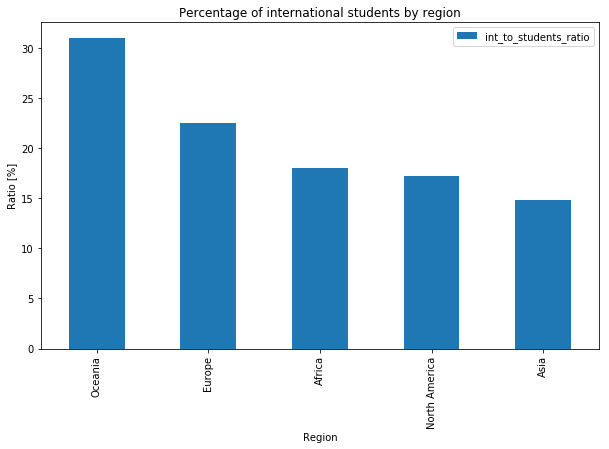

In [93]:
df = region_df.copy()
df['int_to_students_ratio'] = df['total_int_students'] / df['total_students']
region_int_to_students = 100 * df.sort_values('int_to_students_ratio', ascending=False).loc[:, ['int_to_students_ratio']]

p6 = region_int_to_students.plot(kind='bar',title='Percentage of international students by region',figsize=(10,6))
p6.set_ylabel("Ratio [%]")
p6.set_xlabel("Region")

# www.timeshighereducation.com

## Methodology

<span style="color:blue">We also identify the URL of a JSON file that contains the ranking for this dataset and proceed a similar way as for the previous one. It appears that the JSON file contains everything we are interested in, but the number of international faculty and the region. However, since the detailed pages for each university does not contain this information either, there is no point in using BeautifulSoup to extract data from there.</span>

In [62]:
RANKING_URL_TIMES = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

In [63]:
# Function to obtain and format the top n universities in the ranking
def get_list_times(n=200):
    # HTTP GET to fetch the data
    r = requests.get(RANKING_URL_TIMES)
    raw_ranking = r.json()['data']
    
    # Process and clean each entry in the ranking
    ranking = []
    for entry in raw_ranking[0:n]:
        rank = int(entry['rank'].replace('=', '')) # drop the = for tied ranks
        name = entry['name']
        country = entry['location']
        total_students = int(entry['stats_number_students'].replace(',', ''))
        total_int_students = int(float(entry['stats_pc_intl_students'].replace('%', '')) / 100.0 * total_students)
        total_faculty = int(total_students / float(entry['stats_student_staff_ratio']))
        ranking.append({'rank': rank, 'name': name, 'country': country, 'total_students': total_students, 'total_int_students': total_int_students, 'total_faculty': total_faculty})   
    
    # Create a dataframe and index it
    df = pd.DataFrame(ranking)
    df = df.set_index('rank')
    df = df.reindex_axis(['name', 'country', 'total_students', 'total_int_students', 'total_faculty'], axis=1)
    return df

# Let's see what this one looks like
times_df = get_list_times()
times_df

,name,country,total_students,total_int_students,total_faculty
rank,,,,,
1,University of Oxford,United Kingdom,20409,7755,1822
2,University of Cambridge,United Kingdom,18389,6436,1687
3,California Institute of Technology,United States,2209,596,339
3,Stanford University,United States,15845,3485,2112
5,Massachusetts Institute of Technology,United States,11177,3800,1284
6,Harvard University,United States,20326,5284,2283
7,Princeton University,United States,7955,1909,958
8,Imperial College London,United Kingdom,15857,8721,1390
9,University of Chicago,United States,13525,3381,2181


<span style="color:blue">As we can see, that dataframe does not contain the region. However, we can infer the region using the data from the first dataframe.

<span style="color:blue">Let's build a mapping from country to region using the first dataframe...</span>

In [64]:
countries_regions_df = top_df.copy().reset_index().loc[:, ['country', 'region']].drop_duplicates()
# Let's add a couple missing ones
countries_regions_df = pd.concat([countries_regions_df, pd.DataFrame([['Russian Federation', 'Europe'], ['Luxembourg', 'Europe']], columns=['country', 'region'])])

<span style="color:blue">... And join that mapping with the times dataframe to get the region column filled in.</span>

In [65]:
times_df = times_df.reset_index().merge(countries_regions_df)
times_df['rank'].astype(int)
times_df = times_df.set_index('rank')
times_df.reindex_axis(['name', 'country', 'region', 'total_students', 'total_int_students', 'total_faculty'], axis=1)
times_df = times_df.sort_index()

# Let's see what it looks like...
times_df.head()

,name,country,total_students,total_int_students,total_faculty,region
rank,,,,,,
1,University of Oxford,United Kingdom,20409,7755,1822,Europe
2,University of Cambridge,United Kingdom,18389,6436,1687,Europe
3,Stanford University,United States,15845,3485,2112,North America
3,California Institute of Technology,United States,2209,596,339,North America
5,Massachusetts Institute of Technology,United States,11177,3800,1284,North America


Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?

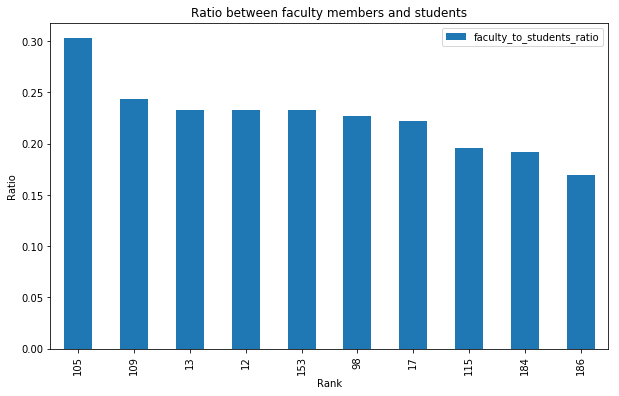

In [95]:
df = times_df.copy()
df['faculty_to_students_ratio'] = df['total_faculty'] / df['total_students']
highest_faculty_to_student_times = df.sort_values('faculty_to_students_ratio', ascending=False).head(10).loc[:, ['name', 'faculty_to_students_ratio']]


p7 = highest_faculty_to_student_times.plot(kind='bar',title='Ratio between faculty members and students',figsize=(10,6))
p7.set_ylabel("Ratio")
p7.set_xlabel("Rank")

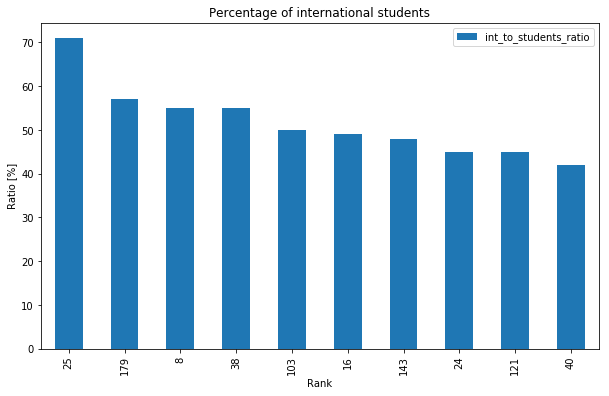

In [96]:
df = times_df.copy()
df['int_to_students_ratio'] = df['total_int_students'] / df['total_students']
highest_int_to_students_times = 100*df.sort_values('int_to_students_ratio', ascending=False).head(10).loc[:, ['name', 'int_to_students_ratio']]

p8 = highest_int_to_students_times.plot(kind='bar',title='Percentage of international students',figsize=(10,6))
p8.set_ylabel("Ratio [%]")
p8.set_xlabel("Rank")

Answer the previous question aggregating the data by (c) country and (d) region.

In [68]:
country_df = times_df.copy()
country_df = country_df.groupby('country').agg({'total_students': 'sum', 'total_int_students': 'sum', 'total_faculty': 'sum'})

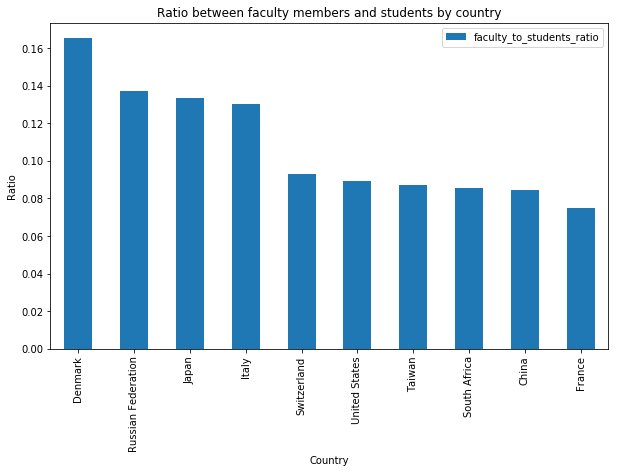

In [98]:
df = country_df.copy()
df['faculty_to_students_ratio'] = df['total_faculty'] / df['total_students']
country_faculty_to_student_times = df.sort_values('faculty_to_students_ratio', ascending=False).head(10).loc[:, ['faculty_to_students_ratio']]

p9 = country_faculty_to_student_times.plot(kind='bar',title='Ratio between faculty members and students by country',figsize=(10,6))
p9.set_ylabel("Ratio")
p9.set_xlabel("Country")


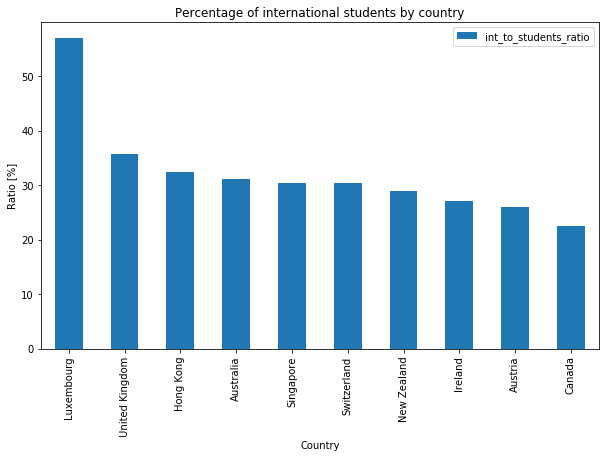

In [101]:
df = country_df.copy()
df['int_to_students_ratio'] = df['total_int_students'] / df['total_students']
country_int_to_students_times = 100 * df.sort_values('int_to_students_ratio', ascending=False).head(10).loc[:, ['int_to_students_ratio']]

p10 = country_int_to_students_times.plot(kind='bar',title='Percentage of international students by country',figsize=(10,6))
p10.set_ylabel("Ratio [%]")
p10.set_xlabel("Country")

In [71]:
region_df = times_df.copy()
region_df = region_df.groupby('region').agg({'total_students': 'sum', 'total_int_students': 'sum', 'total_faculty': 'sum'})

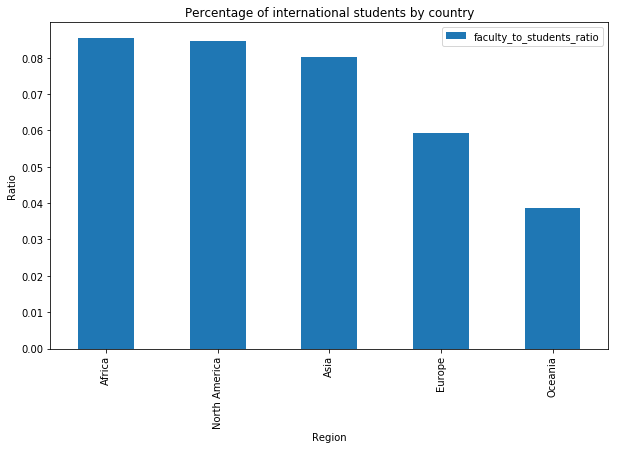

In [104]:
df = region_df.copy()
df['faculty_to_students_ratio'] = df['total_faculty'] / df['total_students']
region_faculty_to_student_times = df.sort_values('faculty_to_students_ratio', ascending=False).loc[:, ['faculty_to_students_ratio']]

p11 = region_faculty_to_student_times.plot(kind='bar',title='Percentage of international students by country',figsize=(10,6))
p11.set_ylabel("Ratio")
p11.set_xlabel("Region")

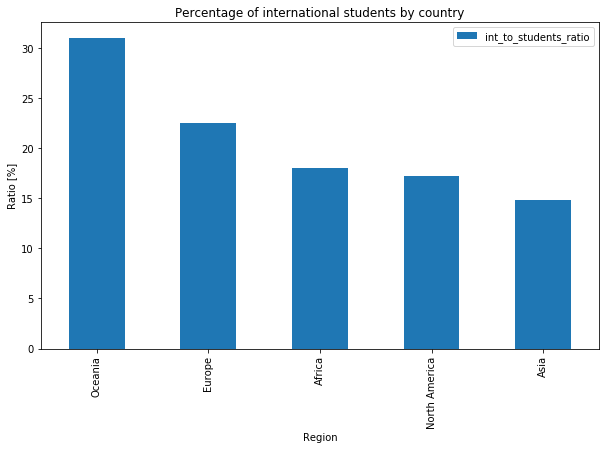

In [105]:
df = region_df.copy()
df['int_to_students_ratio'] = df['total_int_students'] / df['total_students']
region_int_to_students_times = 100*df.sort_values('int_to_students_ratio', ascending=False).loc[:, ['int_to_students_ratio']]

p12 = region_int_to_students_times.plot(kind='bar',title='Percentage of international students by country',figsize=(10,6))
p12.set_ylabel("Ratio [%]")
p12.set_xlabel("Region")

# Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

We observe that university names can differ quite significantly between each ranking, so we opt for the following merging strategy:

1. Merge the two dataframes by country and region, effectively computing a filtered cartesian product of the two rankings.
2. Use a string similarity metric to estimate the similarity between the names in each ranking. We remove common words such as _University_, _of_, etc. to avoid confusing the metric.
3. Sort entries by decreasing similarity and pick one entry for each university name.
4. Filter out matchings with low similarity. We opt for a similarity of >= 0.8 after careful examination of the results.

In [74]:
from difflib import SequenceMatcher

def clean_name(name):
    tmp = name
    for token in ['University', 'of', 'Institute', 'The', 'Technology']:
        tmp = tmp.replace(token, '')
    return tmp.strip()

def similar(n1, n2):
    return SequenceMatcher(None, clean_name(n1), clean_name(n2)).ratio()

In [75]:
SIMILARITY_CUT = 0.8

In [181]:
df1 = top_df.copy()
df1 = df1.reset_index()
df2 = times_df.copy()
df2.loc[df2.country == 'Russian Federation', 'country'] = 'Russia' # Adjust Russia's name
df2 = df2.reset_index()

# Merge both dataframes on country and region
df = df1.merge(df2, on=['country', 'region'], suffixes=['_top', '_times'])

# Compute similarity
df['similarity'] = df[['name_top','name_times']].apply(lambda x: similar(*x), axis=1)

# Select each unique entry with the highest similarity, then filter out entries with too low similarity
merged_df = df.sort_values('similarity', ascending=False).groupby('name_times', as_index=False).first()
merged_df = merged_df.loc[merged_df.similarity >= SIMILARITY_CUT]

# Clean it up a little...
merged_df = merged_df[['name_times', 'country', 'region', 'rank_top', 'rank_times', 'total_students_top', 'total_int_students_top', 'total_faculty_top', 'total_int_faculty', 'total_students_times', 'total_int_students_times', 'total_faculty_times']].rename(columns = {'name_times':'name'})
merged_df = merged_df.set_index('name')
merged_df = merged_df.sort_index()

# Let's see what that looks like
merged_df

,country,region,rank_top,rank_times,total_students_top,total_int_students_top,total_faculty_top,total_int_faculty,total_students_times,total_int_students_times,total_faculty_times
name,,,,,,,,,,,
Aalto University,Finland,Europe,137,190,12147.0,1831.0,1257.0,370.0,12744,2548,630
Aarhus University,Denmark,Europe,119,109,26226.0,3762.0,2316.0,602.0,25167,3020,1759
Australian National University,Australia,Oceania,20,48,14442.0,5551.0,1600.0,927.0,15986,5595,828
Boston University,United States,North America,81,70,25662.0,7041.0,3157.0,379.0,24833,6208,2887
Brown University,United States,North America,53,50,9251.0,1825.0,1303.0,379.0,8898,1779,831
Cardiff University,United Kingdom,Europe,137,162,24565.0,6090.0,2755.0,705.0,24186,6288,1791
Carnegie Mellon University,United States,North America,47,24,13356.0,6385.0,1342.0,425.0,12676,5704,938
Chinese University of Hong Kong,Hong Kong,Asia,46,58,18037.0,4824.0,2208.0,1074.0,18072,5602,1044
City University of Hong Kong,Hong Kong,Asia,49,119,9240.0,3273.0,1349.0,1027.0,9240,3234,825


<span style="color:blue">It appears our merging strategy managed to match 142 university names. Not bad...</span>

# Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

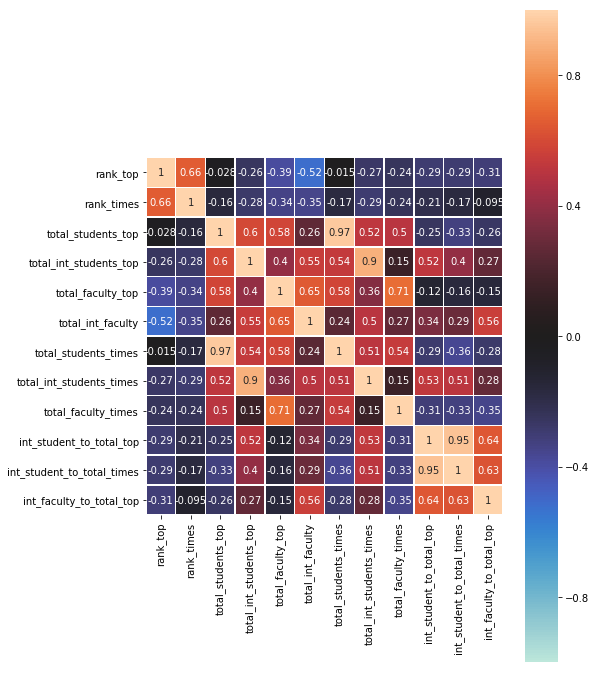

In [119]:
df_ratio = merged_df.copy()
df_ratio['int_student_to_total_top'] = df_ratio['total_int_students_top']/df_ratio['total_students_top']
df_ratio['int_student_to_total_times'] = df_ratio['total_int_students_times']/df_ratio['total_students_times']

df_ratio['int_faculty_to_total_top'] = df_ratio['total_int_faculty']/df_ratio['total_faculty_top']

plt.figure(figsize=(8, 12))
sns.heatmap(correlations, annot=True, center =0,square=True,linewidths=.5, vmax = 1.0, vmin = -1.0)

The heatmap allows to see the strong correlations...

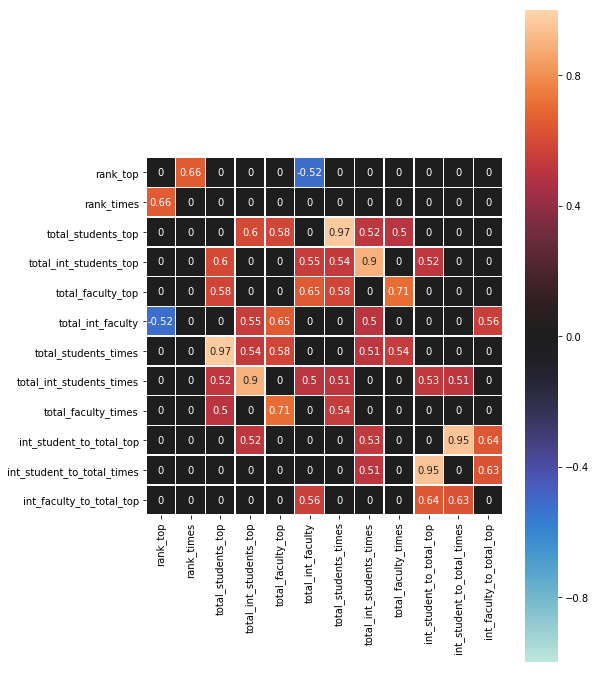

In [131]:
correlations = df_ratio.corr()
# Keep correlations smaller than 1 and abs(correlations) > 0.5
strong_correlations = correlations[((correlations >= 0.5) | (correlations <= -0.5)) & (correlations < 1)]
# Keep correlations smaller than 0.5 and abs(correlations) > 0.3
moderate_correlations = correlations[((correlations >= 0.3) | (correlations <= -0.3)) & (abs(correlations) < 0.5)]
# Keep correlations smaller than 0.3 and abs(correlations) > 0.1
weak_correlations = correlations[((correlations >= 0.1) | (correlations <= -0.1)) & (abs(correlations) < 0.3)]

strong_correlations = strong_correlations.replace(np.nan, 0)
moderate_correlations = moderate_correlations.replace(np.nan, 0)
weak_correlations = weak_correlations.replace(np.nan, 0)

# Only the strong correlations are non-zero, this permits a better visualization
plt.figure(figsize=(8, 12))
sns.heatmap(strong_correlations, annot=True, center =0,square=True,linewidths=.5, vmax = 1.0, vmin = -1.0)

Some interesting strong positive correlations are found between:
* The total number of students and the number of international students
* The number of international members in faculty and the number of international students
* The internal student ratio and international members in faculty ratio

An interesting strong negative correlation is found between:
* The ranking on top university and the number of international members in faculty

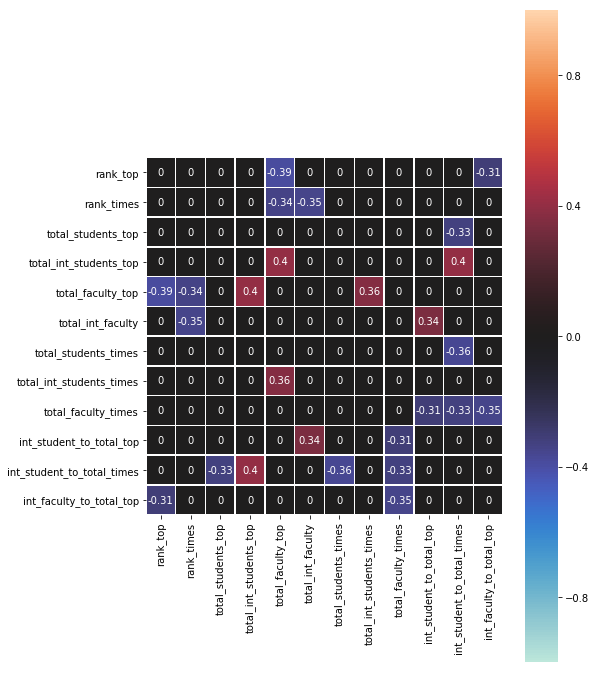

In [130]:
# Only the moderate correlations are non-zero, this permits a better visualization
plt.figure(figsize=(8, 12))
sns.heatmap(moderate_correlations, annot=True, center =0,square=True,linewidths=.5, vmax = 1.0, vmin = -1.0)

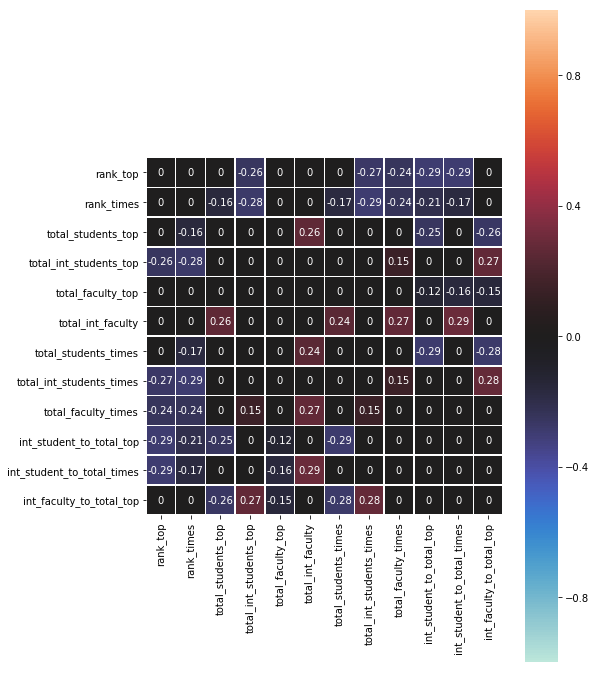

In [132]:
# Only the weak correlations are non-zero, this permits a better visualization
plt.figure(figsize=(8, 12))
sns.heatmap(weak_correlations, annot=True, center =0,square=True,linewidths=.5, vmax = 1.0, vmin = -1.0)

In summary, aucune correlation positive avec le ranking

In [196]:
# Description of ranking by country

rank_country_df = merged_df.copy()
rank_country_df = rank_country_df.groupby('country').mean()
#rank_country_df = rank_country_df[['rank_top', 'rank_times']]
rank_country_df
# Description of ranking by region

rank_region_df = merged_df.copy()
rank_region_df = rank_region_df.groupby('region').mean()
#rank_region_df = rank_region_df[['rank_top', 'rank_times']]
rank_region_df


,rank_top,rank_times,total_students_top,total_int_students_top,total_faculty_top,total_int_faculty,total_students_times,total_int_students_times,total_faculty_times
region,,,,,,,,,
Africa,191.000000,171.000000,19593.000000,3325.000000,1733.000000,379.000000,20775.000000,3739.000000,1775.000000
Asia,55.105263,97.842105,25799.368421,4150.631579,3302.421053,1081.894737,27286.263158,4097.631579,2181.263158
Europe,101.468750,106.359375,21662.890625,5589.359375,2653.828125,918.312500,21081.875000,5395.796875,1458.015625
North America,81.360000,57.360000,29541.060000,5450.480000,3555.380000,828.760000,29474.340000,5211.620000,2495.860000
Oceania,78.500000,90.375000,30646.625000,10450.625000,2224.625000,1073.250000,32355.625000,9870.250000,1256.000000


# Can you find the best university taking in consideration both rankings? Explain your approach.